# Reconstructing maps of trend per grid cell

In [65]:
# specify the file description that was used to save all the data
fnm_root = "rx1day-era5-260126"

In [66]:
import xarray as xr, numpy as np, pandas as pd, glob, cartopy

import warnings; warnings.filterwarnings("ignore", category = FutureWarning) # otherwise there will be a LOT of warnings
import warnings; warnings.filterwarnings("ignore", category = UserWarning) # otherwise there will be a LOT of warnings

import matplotlib, matplotlib.pyplot as plt, matplotlib.colors as mcl
matplotlib.rcParams['savefig.bbox'] = "tight"    # always save with tight bounding box
mapproj = cartopy.crs.PlateCarree()

# function to reshape dataframe into map
def vec2map(x, mask):
    
    # reconstruct vector into map
    # create an empty map with NA in same cells as masks
    arr = mask.where(np.isnan(mask), 0)
    
    # get coordinates of non-empty cells
    px = np.argwhere(~np.isnan(mask.values))
    
    # Transfer vector values into non-empty cells in array
    if len(px) == len(x):
        for i in list(range(len(px))): arr[px[i,0], px[i,1]] = x[i]
        return arr
    else:
        print(str(len(x))+" values, but "+str(len(px))+" cells")
        return


class MidpointNormalise(matplotlib.colors.Normalize):
    """ From: https://matplotlib.org/users/colormapnorms.html"""
    def __init__(self, vmin=None, vmax=None, midpoint=0, clip=False):
        self.midpoint = midpoint
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...

        result, is_scalar = self.process_value(value)
        self.autoscale_None(result)

        vlargest = max( abs( self.vmax - self.midpoint ), abs( self.vmin - self.midpoint ) )
        x, y = [ self.midpoint - vlargest, self.midpoint, self.midpoint + vlargest], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

## Reshape dataframe into maps

Don't change anything in the cell below

In [ ]:
# load target map showing original shape of data
tmplt = xr.open_dataset("map-tmplt_"+fnm_root+".nc")
tmplt = tmplt[list(tmplt.data_vars)[0]]

# load all the flattened results and compile into a single dataframe
df = pd.concat([pd.read_csv(fnm, index_col = 0) for fnm in sorted(glob.glob("flattened-res/"+fnm_root+"*.csv"))], axis = 0)

# reconstruct map
res = xr.merge([vec2map(df.loc[r], tmplt).rename(r) for r in df.index])

# # replace infinite values with very high value
# res["PR"] = res.PR.where(np.isfinite(res.PR), 1000).where(~np.isnan(res.PR))

# save
res.to_netcdf("gridded-trend_"+fnm_root+".nc")

# Maps of trend per grid cell

Try to customise the maps to your event:
- change the labels
- change the colourmap (https://matplotlib.org/stable/users/explain/colors/colormaps.html)
  - For temperatures, 'YlOrRd' is a good choice, and for temperature anomalies/changes, 'RdBu_r'
  - For precipitation, 'YlGnBu' is a good choice, and for rainfall anomalies/changes, 'BrBG'
- set the colour scale (using vmax and vmin) to highlight the worst-affected areas

In [55]:
# load the reconstructed maps - this has one variable for each of the outputs from the R trend fitting
res = xr.open_dataset("gridded-trend_"+fnm_root+".nc").sel(lon = slice(-10,0), lat = slice(45,33))

## Change in relative intensity

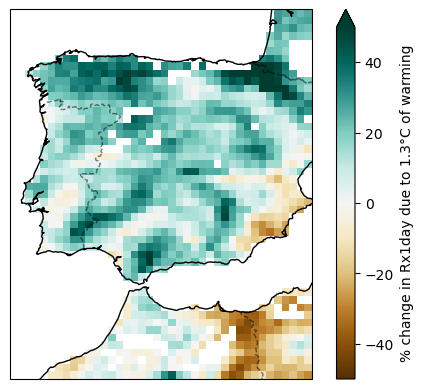

In [60]:
res.dI_rel_pi.plot(subplot_kws = {"projection" : mapproj},
                cmap = "BrBG", vmax = 50, vmin = -50,
                cbar_kwargs = {"location" : "right",
                               "label" : "% change in Rx1day due to 1.3°C of warming"}) 
ax = plt.gca()
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.5, ls = "--")
# ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["left", "bottom"])
plt.savefig("fig/gridded-trend_dI-rel-pi_era5_gmst+nao.png")

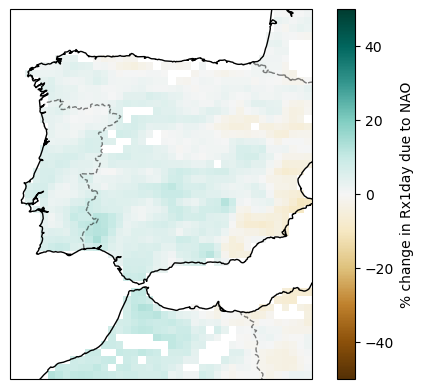

In [61]:
res.dI_rel_naoneutral.plot(subplot_kws = {"projection" : mapproj},
                cmap = "BrBG", vmax = 50, vmin = -50,
                cbar_kwargs = {"location" : "right",
                               "label" : "% change in Rx1day due to NAO"}) 
ax = plt.gca()
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.5, ls = "--")
# ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["left", "bottom"])
plt.savefig("fig/gridded-trend_dI-rel-naoneutral_era5_gmst+nao.png")

## Return period

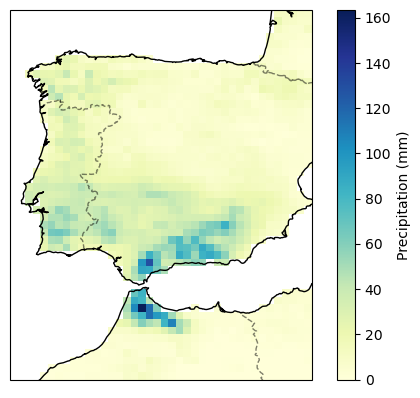

In [57]:
res.event_magnitude.plot(subplot_kws = {"projection" : mapproj},
                         cmap = "YlGnBu",
                         cbar_kwargs = {"location" : "right",
                                        "label" : "Precipitation (mm)"}) 
ax = plt.gca()
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.5, ls = "--")
plt.savefig("fig/gridded-trend_ev260402_era5_gmst+nao.png")

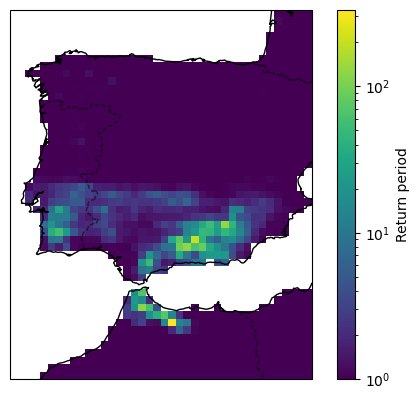

In [58]:
res.return_period.plot(subplot_kws = {"projection" : mapproj},
                cmap = "viridis", norm = mcl.LogNorm(),
                cbar_kwargs = {"location" : "right",
                               "label" : "Return period"}) 
ax = plt.gca()
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.5, ls = "--")
# ax.gridlines(color = "k", alpha = 0.1, draw_labels = ["left", "bottom"])
plt.savefig("fig/gridded-trend_rp260402_era5_gmst+nao.png")